# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Other Analysis](#eda_continued)

<a id='intro'></a>
## Introduction
Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, an exploratory analysis is performed on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. A comparison of the system usage is done between three large cities: New York City, Chicago, and Washington, DC. Also, I have looked if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

This project has been realised in the case of the Udacity Nanodegree "[Data Analysis](https://eu.udacity.com/course/data-analyst-nanodegree--nd002)".

<a id='pose_questions'></a>
## Posing Questions

Some questions that could be answered by data:

1/ Are the clients more casual users or short-term users?<br>
2/ Is there a difference in the distance covered between the two types of users?


<a id='wrangling'></a>
## Data Collection and Wrangling

In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

If you visit these pages, you will notice that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly. 

However, the data were already collected in the case of the project and can be found in the folder `/original data/`. While the original data for 2016 is spread among multiple files for each city, the files in the `/original data/` folder collect all of the trip data for the year into one file per city. Some data wrangling of inconsistencies in timestamp format within each city has already been performed for you. In addition, a random 2% sample of the original data is taken to make the exploration more manageable. 

In [7]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.

In [8]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        # Use the csv library to set up a DictReader object. ##
        trip_reader = csv.DictReader(f_in)
        
        ## Use a function on the DictReader object to read the     ##
        ## first trip from the data file and store it in a variable.     ##
        first_trip = trip_reader.__next__()
        
        ## Use the pprint library to print the first trip. ##
        pprint(first_trip)
        
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./original data/NYC-CitiBike-2016.csv',
              './original data/Chicago-Divvy-2016.csv',
              './original data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

Form the function, we see the printout of each city name (which has been parsed from the data file name) that the first trip has been parsed in the form of a dictionary. When you set up a `DictReader` object, the first row of the data file is normally interpreted as column names. Every other row in the data file will use those column names as keys, as a dictionary is generated for each row.

This will be useful since we can refer to quantities by an easily-understandable label instead of just a numeric index. For example, if we have a trip stored in the variable `row`, then we would rather get the trip duration from `row['duration']` instead of `row[0]`.

<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

You will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. Use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, you will convert the Washington labels to match the other two.


Creation of helper functions to address each of the cleaning tasks described above.

In [9]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    """
    
    # YOUR CODE HERE
    if city == 'NYC':
        duration = float(datum['tripduration']) / 60
    elif city == 'Chicago':
        duration = float(datum['tripduration']) / 60
    elif city == 'Washington':
        seconds = float(datum['Duration (ms)']) / 1000
        duration = seconds / 60
    return duration


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [10]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.
    """

    if city == 'NYC':
        dt = datetime.strptime(datum['starttime'],'%m/%d/%Y %H:%M:%S') 
    elif city == 'Chicago':
        dt = datetime.strptime(datum['starttime'],'%m/%d/%Y %H:%M') 
    elif city == 'Washington':
        dt = datetime.strptime(datum['Start date'],'%m/%d/%Y %H:%M') 
    month = dt.month
    hour = dt.hour
    day_of_week = dt.strftime('%A')
    
    return (month, hour, day_of_week)

# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [11]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. 
    """

    if city == 'Washington':
        if datum['Member Type'] == 'Registered':
            user_type = 'Subscriber'
        elif datum['Member Type'] == 'Casual':
            user_type = 'Customer'
    else:
        user_type = datum['usertype']
    
    return user_type


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

With the use of the helper functions, creation of a condensed data file for each city consisting only of the data fields indicated above. 

In [12]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        ## Set up csv DictReader object ##
        trip_reader = csv.DictReader(f_in)

        # Collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}
            ## TODO: use the helper functions to get the cleaned data from  ##
            ## the original data dictionaries.                              ##
            ## Note that the keys for the new_point dictionary should match ##
            ## the column names set in the DictWriter object above.         ##
            new_point['duration'] = duration_in_mins(row, city)
            new_point['month'] = time_of_trip(row, city)[0]
            new_point['hour'] = time_of_trip(row, city)[1]
            new_point['day_of_week'] = time_of_trip(row, city)[2]
            new_point['user_type'] = type_of_user(row, city)

            ## Write the processed information to the output file.     ##
            ## see https://docs.python.org/3/library/csv.html#writer-objects ##
            trip_writer.writerow(new_point)    
            

In [13]:
# Run this cell to check your work
city_info = {'Washington': {'in_file': './original data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './condensed data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './original data/Chicago-Divvy-2016.csv',
                         'out_file': './condensed data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './original data/NYC-CitiBike-2016.csv',
                     'out_file': './condensed data/NYC-2016-Summary.csv'}}
#out_file are created with the condensed data
for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. 

The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. 

In [14]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data (filename) and reports the number of
    trips (made by total overall, by the subscribers and by customers) 
    and the proportion made by each type (subscribers/customers)
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        #proportion of each type
        prop_sub = n_subscribers / n_total *100
        prop_cust = n_customers / n_total *100
        
        # return tallies as a tuple
        return(n_total, n_subscribers, n_customers, round(prop_sub,2), round(prop_cust,2))

**Question**: Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?

In [15]:
data_file_Washington = './condensed data/Washington-2016-Summary.csv'
data_file_Chicago = './condensed data/Chicago-2016-Summary.csv'
data_file_NYC = './condensed data/NYC-2016-Summary.csv'

print('Washington',number_of_trips(data_file_Washington))
print('Chicago',number_of_trips(data_file_Chicago))
print('NYC',number_of_trips(data_file_NYC))

Washington (66326, 51753, 14573, 78.03, 21.97)
Chicago (72131, 54982, 17149, 76.23, 23.77)
NYC (276798, 245896, 30902, 88.84, 11.16)


**Answer**: 
- Which city has the highest number of trips? NYC with 276798 trips, in front of Chicago with 72131 trips and Washington with 66326 trips.
- Which city has the highest proportion of trips made by subscribers? NYC have the highest proportion of trips made by subscribers (88.8%) in front of Washington (78%) and Chicago (76.2%).
- Which city has the highest proportion of trips made by short-term customers? Logically, Chicago has the highest proportion of trips made by short-term customers with 23.8%, then Washington with 22% and then NYC with 11.2%.

**Question**: Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

In [16]:
## HINT: The csv module reads in all of the data as strings, including  ##
## numeric values. You will need a function to convert the strings      ##
## into an appropriate numeric type before you aggregate data.          ##

def type_duration_of_trips(filename):
    """
    This function reads in a file with trip data (filename) and reports the average trip lenght, the proportion of
    trips longer than 30min.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        trip_shorter_30min = 0
        trip_longer_30min = 0
        total_time = 0
        
        # tally up ride types
        for row in reader:
            total_time += float(row['duration'])
            if float(row['duration']) <= 30:
                trip_shorter_30min += 1
            else:
                trip_longer_30min += 1
        
        # compute total number of rides
        trip_total = trip_shorter_30min + trip_longer_30min
        
        #average trip lenght
        average_trip_total = total_time / trip_total
        
        #proportion of trip longer than 30min
        prop_longer = trip_longer_30min / trip_total *100
        
        # return tallies as a tuple
        return(round(average_trip_total,2), round(prop_longer,2))

In [17]:
data_file_Washington = './condensed data/Washington-2016-Summary.csv'
data_file_Chicago = './condensed data/Chicago-2016-Summary.csv'
data_file_NYC = './condensed data/NYC-2016-Summary.csv'

print('Washington', type_duration_of_trips(data_file_Washington))
print('Chicago', type_duration_of_trips(data_file_Chicago))
print('NYC', type_duration_of_trips(data_file_NYC))

Washington (18.93, 10.84)
Chicago (16.56, 8.33)
NYC (15.81, 7.3)


**Answer**: 
- What is the average trip length for each city? Washington: 18.9 min, Chicago: 16.6 min, NYC: 15.8 min
- What proportion of rides made in each city are longer than 30 minutes? There are 10.8% in Washington, Chicago 8.3% and NYC 7.3% of the rides longer than 30 minutes.

**Question**: Dig deeper into the question of trip duration based on ridership. Within Chicago, which type of user takes longer rides on average: Subscribers or Customers?


In [18]:
def user_time_ride(filename):
    """
    This function reads in a file with trip data and reports the trip duration depending on 
    the type of user: Subscribers of Customers
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        total_time_sub = 0
        total_time_cus = 0
        
        #get number of rides for each type with from previous function
        total_sub = number_of_trips(filename)[1]
        total_cus = number_of_trips(filename)[2]
        
        #tally up customer types and get the ride time
        for row in reader:
            if row['user_type'] == 'Subscriber':
                total_time_sub += float(row['duration'])
            else:
                total_time_cus += float(row['duration'])
            
        #average time of each type of user
        avg_time_sub = total_time_sub / total_sub
        avg_time_cus = total_time_cus / total_cus
        
        # return tallies as a tuple
        return(round(avg_time_sub,2), round(avg_time_cus),2)

In [19]:
data_file_Washington = './condensed data/Washington-2016-Summary.csv'
data_file_Chicago = './condensed data/Chicago-2016-Summary.csv'
data_file_NYC = './condensed data/NYC-2016-Summary.csv'

print('Washington', user_time_ride(data_file_Washington))
print('Chicago', user_time_ride(data_file_Chicago))
print('NYC', user_time_ride(data_file_NYC))

Washington (12.53, 42, 2)
Chicago (12.07, 31, 2)
NYC (13.68, 33, 2)


**Answer**: For the city of **Chicago**, the average Subscriber trip duration is 12 minutes and the average Customer trip duration is 31 minutes.

<a id='visualizations'></a>
### Visualizations

While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. 

In [20]:
# load library
import matplotlib.pyplot as plt

# allows for plots to be displayed inline with the notebook. 
%matplotlib inline 


In [21]:
#collect all of the trip times as a list and then use pyplot functions to generate a histogram of trip times.     ##

def histo_trip_time(filename):
    """
    This function reads in a file with trip data (filename) and plot the distribution of trip duration
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialisation of the list contaning the duration data of all the users
        data = []

        #filling the data list
        for row in reader:
            duration = float(row['duration'])
            data.append(round(duration, 2))
            
        #plotting the histogram
        plt.hist(data)
        plt.title('Distribution of Trip Durations')
        plt.xlabel('Duration (m)')
        plt.show()

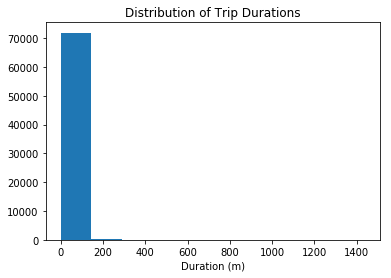

None


In [24]:
data_file_Chicago = './condensed data/Chicago-2016-Summary.csv'
print(histo_trip_time(data_file_Chicago))

In [25]:
import numpy as np

def histo_trip_time_user(filename):
    """
    This function reads in a file with trip data (filename) and plot the distribution of 
    trip duration in the different type of user.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialisation of the list contaning the duration data of all the users
        data_sub = []
        data_cus = []

        #filling the data list
        for row in reader:
            if row['user_type'] == 'Subscriber':
                duration_sub = float(row['duration'])
                data_sub.append(round(duration_sub, 2))
            else:
                duration_cus = float(row['duration'])
                data_cus.append(round(duration_cus, 2))
            
        #creation of a list from 0 to 75 with a step of 5 to use as bin of the histograms
        bins = list(np.arange(0,75,5))
        
        #plotting the histograms
        plt.hist(data_sub, bins=bins, range=(0,75))
        plt.title('Distribution of Trip Durations of Subscribers')
        plt.xlabel('Duration (m)')
        plt.show()
        
        plt.hist(data_cus, bins=bins, range=(0,75))
        plt.title('Distribution of Trip Durations of Customers')
        plt.xlabel('Duration (m)')
        plt.show()


**Question**: Plot the distribution of trip times for the Subscribers in Chicago, and for only the Customers. Limits are added to the plots so that only trips of duration less than 75 minutes are plotted. 

For each group, where is the peak of each distribution? How would you describe the shape of each distribution?

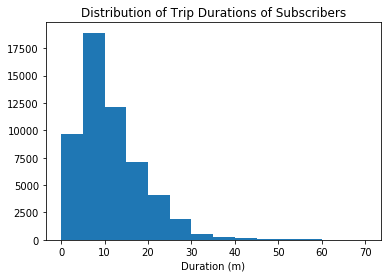

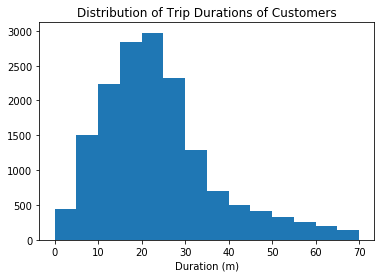

None


In [26]:
data_file_Chicago = './condensed data/Chicago-2016-Summary.csv'
print(histo_trip_time_user(data_file_Chicago))

**Answer**: 
- Where is the peak of each distribution? For the Subscribers, the peak of ride duration is between 5 and 10 minutes. For the Customers, the peak of duration is between 20 and 25minutes.
- How would you describe the shape of each distribution? Both distributions are asymmetrical right skewed.

<a id='eda_continued'></a>
## Other Analysis

**Questions and Answers**: On the city of **Chicago**:
- How does ridership differ by month? Which month has the highest ridership (average duration and number of user)?

There is a varation of the number of users (Fig.1) and of the duration of rides (Fig.2) during the year. From May to October, there are more customers and from April to September rides are longer than the rest of the year. The month with the highest nomber of use with the longest rides is July. One explanation of this variation could be the weather.

- Does the ratio of Subscriber trips to Customer trips change depending on the month?

From the Fig. 2, we observe that during this higher months the proportion of Customers users is strongly increasing (30% of Customers users in July). During the rest of the year, the number of use by the Customers is not so important (5% to 15%).
We also observe that the average duration of rides by the Subscribers does not have a large variation during the year (Fig. 3). The varation of duration observed is mainly due to a varation in the Customers.

In [27]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#function to sum the elements of list
def sum_list(list_):
    s = 0
    for i in list_:
        s += i
    return s

#Main Function
def ride_season(filename):
    """
    This function reads in a file with trip data and plot during the year the number of user, the proportion of 
    users in the different types, the average duration of ride in the different types.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialisation of varaiables
        sub = {} #dictionnary with information for Subscribers
        cus = {} #dictionnary with information for Customers
            #structure each dict = {month1: [12, 15, 33, 17], month2: [durations], ...}
        n_sub = [0]*12 #list of the number of Subscribers in the different months
        n_cus = [0]*12 #list of the number of Customers in the different months
        n_total = [0]*12 #list of the number of Users in the different months
        n_prop_sub = [0]*12 #list of the proportion of Subscribers in the different months
        n_prop_cus = [0]*12 #list of the proportion of Customers in the different months
        avg_duration_sub = [0]*12 #list of the average trip duration of Subscribers in the different months
        avg_duration_cus = [0]*12 #list of the average trip duration of Customers in the different months
        
        #TALLY UP DATA and ANALYSIS
        #insert the data into dictionnary depending of the type and the month
        for row in reader:
            duration = float(row['duration'])
            user = row['user_type']
            month = int(row['month'])
            
            if user == 'Subscriber':
                if month in sub:
                    sub[month].append(duration) #month already in the dictioannary
                else:
                    sub[month] = [duration] #month not in the dictionnary
                    
            else:
                if month in cus:
                    cus[month].append(duration)
                else:
                    cus[month] = [duration]
                    
        #obtain the number of user total and per type
        for i in range(0,12):
            n_sub[i]= len(sub[i+1])
            n_cus[i] = len(cus[i+1])
            n_total[i] = n_sub[i] + n_cus[i]
            n_prop_sub [i] = n_sub[i] / n_total[i] * 100
            n_prop_cus [i] = n_cus[i] / n_total[i] * 100
            
        #obtain the average of duration per type
        for i in range(0,12):
            #avg_duration_sub[i] = sum_list(sub[i+1]) / n_sub[i] #original
            #avg_duration_cus[i] = sum_list(cus[i+1]) / n_cus[i] #original
            avg_duration_sub[i] = np.mean(sub[i+1])
            avg_duration_cus[i] = np.mean(cus[i+1])
        
        #PLOTS (Bar)
        #data for the x axis
        ind = np.arange(12) 
        months = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 
                         'Oct', 'Nov', 'Dec' )
        
        #plot the number of total user during the year
        p1 = plt.bar(ind,n_total )
        plt.ylabel('number of users')
        plt.title('Number of total users per month')
        plt.xticks(ind, months)
        print('Figure 1')
        plt.show()
            
        #Stacked Bar Graph of proportion for user per type during the different months 
        p2 = plt.bar(ind, n_prop_sub)
        p3 = plt.bar(ind, n_prop_cus, bottom=n_prop_sub)
        plt.ylabel('pourcentage of total user')
        plt.title('Ratio of users by type and month')
        plt.xticks(ind, months)
        plt.legend((p2[0], p3[0]), ('Subscribers', 'Customers'))     
        print('Figure 2')
        plt.show()
        
        #histogram of both distribution (Cus and Sub) on same plot
        width=0.35 #width of the bars
        fig,ax = plt.subplots(figsize=(8,6))
        bar1 = ax.bar(ind, n_sub, width) #(x, y, width)
        bar2 = ax.bar(ind+width, n_cus, width)
        ax.set_title('Distributions of Customers and Subscribers number of rides')
        ax.set_xticklabels(months)
        ax.set_xticks(ind + width/2)
        ax.set_ylabel('Count of rides')
        ax.legend((bar1[0], bar2[0]), ('Subscribers', 'Customers'), loc='upper right')
        print ('Figure 2B')
        plt.show()
        
        #Stacked Bar Graph of average duration of ride depending of type of user
        p4 = plt.bar(ind, avg_duration_sub)
        p5 = plt.bar(ind, avg_duration_cus, bottom=avg_duration_sub)
        plt.ylabel('average duration (min)')
        plt.title('Average duration of ride by type and month')
        plt.xticks(ind, months)
        plt.legend((p4[0], p5[0]), ('Subscribers', 'Customers'))
        print('Figure 3')
        plt.show()
                        

Figure 1


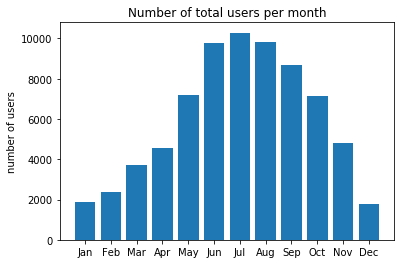

Figure 2


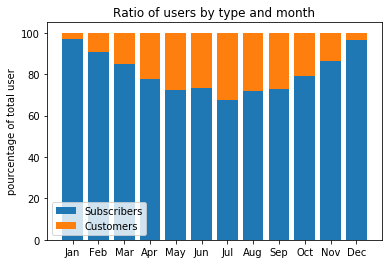

Figure 2B


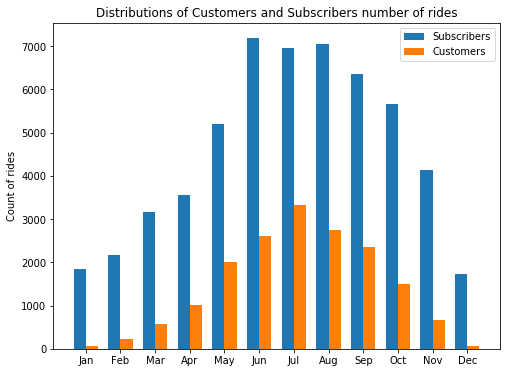

Figure 3


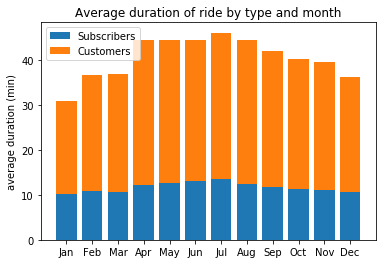

None


In [28]:
data_file_Chicago = './condensed data/Chicago-2016-Summary.csv'
print(ride_season(data_file_Chicago))
